In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate as si

plt.style.use("../paper_small.mplstyle")

In [2]:
df_exp = pd.read_csv(
    "BaZrS3_Raman_785nm_Norm.txt",
    delimiter="\t",
    header=0,
    index_col="X_BaZrS3_785_TD",
)

s_exp = df_exp["Y_BaZrS3_785_300K_8552_300K_Cut_NtV"]
s_exp.name = "intensity_raman_unpolarized"
s_exp.index.name = "frequency_cm"
s_exp.to_csv("data_bzs_raman_300K.csv")
s_exp

frequency_cm
-698.293    0.003997
-698.117    0.002255
-697.941    0.002174
-697.766    0.004122
-697.591    0.003396
              ...   
 997.008    0.005069
 997.118    0.007623
 997.228    0.005354
 997.337    0.008309
 997.448    0.000000
Name: intensity_raman_unpolarized, Length: 12129, dtype: float64

In [3]:
index_col = "frequency_cm"
df_pdos = pd.read_csv("outfile.2pdos.csv", index_col=index_col)
df_cdos = pd.read_csv("outfile.phonon_dos_convolutions.csv", index_col=index_col)

s_pdos = df_pdos["2PDOS"]
s_cdos = df_cdos.dos_weighted_convoluted
s_wdos = df_pdos["2wDOS"]

df_pdos.columns

Index(['frequency', '2PDOS', '2PDOS_1', '2PDOS_2', '2wDOS', '2wDOS_1',
       '2wDOS_2', 'DOS_convolution', 'DOS_convolution_1', 'DOS_convolution_2'],
      dtype='object')

In [4]:
# interpolate to same grid
# fit out the intensity


def interpolate(
    s: pd.Series,
    x: np.ndarray,
    kind: str = "cubic",
    fill_value: float = 0.0,
    x_scale: float = 1.0,
):
    _s = s.dropna()
    _x = np.asarray(_s.index) * x_scale
    _y = np.asarray(_s)

    f = si.interp1d(_x, _y, kind=kind, fill_value=fill_value, bounds_error=False)

    return pd.Series(f(x), index=x, name=s.name)


x = np.linspace(-800, 800, 10000)

s_exp_interpolated = interpolate(s_exp, x)
x_scale = 1.0  # 1.05
s_cdos_interpolated = interpolate(s_cdos, x, x_scale=x_scale)
s_pdos_interpolated = interpolate(s_pdos, x, x_scale=x_scale)
s_wdos_interpolated = interpolate(s_wdos, x, x_scale=x_scale)

$$
\begin{align*}
\min_{c} \|x - cy\|^2
&= \min_{c} (x - cy)(x - cy) \\
&= \min_{c} \underbrace{x^2 + cy^2 - 2cx \cdot y}_{f(x,y)} \\
\frac{\partial f}{\partial c} &= 2cy^2 - 2x \cdot y = 0 \\
&\implies cy^2 = x \cdot y \\
&\implies c = \frac{x \cdot y}{y^2}
\end{align*}
$$

In [5]:
# match the intensities
def match(s1, s2, xmin=10):
    mask = np.array((s1.index < -xmin) | (s1.index > xmin))

    _x = np.asarray(s1)[mask]
    _y = np.asarray(s2)[mask]
    xy = _x @ _y
    yy = _y @ _y
    pref = xy / yy

    return pref * s2

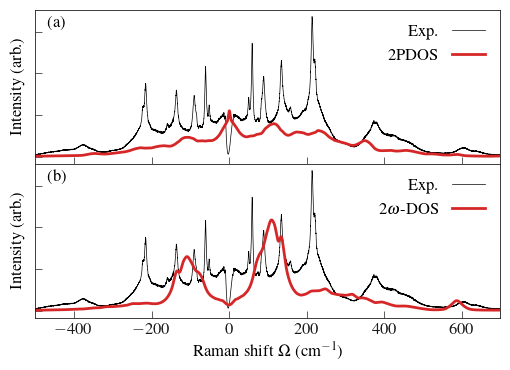

In [6]:
# compare 2PDOS vs 2wDOS
fig, axs = plt.subplots(2, 1, figsize=(6, 4), sharex=True)  # , figsize=(10, 15))
fig.subplots_adjust(hspace=0.0)

s0 = s_exp_interpolated


ax = axs[0]
_scale = 0.5
_s = _scale * match(s0, s_pdos_interpolated)

s0.plot(ax=ax, color="k", lw=0.5)
_s.plot(ax=ax, color="C3", lw=2)
# ax.set_title("Matched 2PDOS")
kw_legend = {"frameon": False, "markerfirst": False}
ax.legend(["Exp.", "2PDOS"], **kw_legend)


ax = axs[1]
_s = match(s0, s_wdos_interpolated)
s0.plot(ax=ax, color="k", lw=0.5)
_s.plot(ax=ax, color="C3", lw=2)
ax.legend(["Exp.", r"$2\omega$-DOS"], **kw_legend)

ax.set_xlim(-500, 700)
ax.set_xlabel(r"Raman shift $\Omega$ (cm$^{-1}$)")


for ax in axs:
    ax.set_yticklabels([])
    ax.set_ylabel("Intensity (arb.)")

for _ax, _l in zip(axs, ["(a)", "(b)"]):
    _ax.text(-470, 0.875 * _ax.get_ylim()[1], _l)

file = "plot_bzs_pdos.pdf"
fig.savefig(file)
fig.savefig(Path(file).stem + ".png")